# reaching_go_spout_bar_nov22

Quick analysis of instrumental reaching

In [84]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *
from trialexp.process.pycontrol_utils import *
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create an experiment object


In [12]:
# Only analyze an experimental session

pycontrol_dir = 'Z:\\Teris\\ASAP\\pycontrol\\reaching_go_spout_nov22\\'
# filename = 'kms060-2023-02-07-124852.txt'
filename = 'kms062-2023-02-06-112451.txt'



### Analyze events and state

In [13]:
#Create experiment object
exp_cohort = Experiment(pycontrol_dir+filename, update = True) #TODO
session = exp_cohort.sessions[0]

# Parse event data
df_events = parse_events(session)

# separate into trials
trigger = ('waiting_for_spout','state_change')
df_events = add_trial_number(df_events, trigger)
df_events

,state,event_name,time,trial_number
1,short_break,state_change,0,0
2,short_break,bar_off,345,0
3,short_break,bar,425,0
4,short_break,bar_off,795,0
5,short_break,bar,1292,0
...,...,...,...,...
550,busy_win,bar,201003,20
551,busy_win,bar_off,201085,20
552,busy_win,bar,201102,20
553,busy_win,bar_off,201118,20


# Analyze rewards

In [70]:
df_reward = df_events[df_events.event_name == 'US_delay_timer']

## Analyze the first spout time

In [81]:
df_first_spout = df_events[(df_events.state=='waiting_for_spout') & (df_events.event_name =='spout')].copy()
df_trial_start = df_events[(df_events.state=='waiting_for_spout') & (df_events.event_name =='state_change')].copy()
assert len(df_first_spout) == len(df_trial_start)

df_first_spout['time_first_spout'] = (df_first_spout.time.values - df_trial_start.time.values)/1000 #time is in miliseconds
df_first_spout.trial_number = df_first_spout.trial_number.astype(str) #hack to force seaborn to treat this as categoric variable

## Plotting

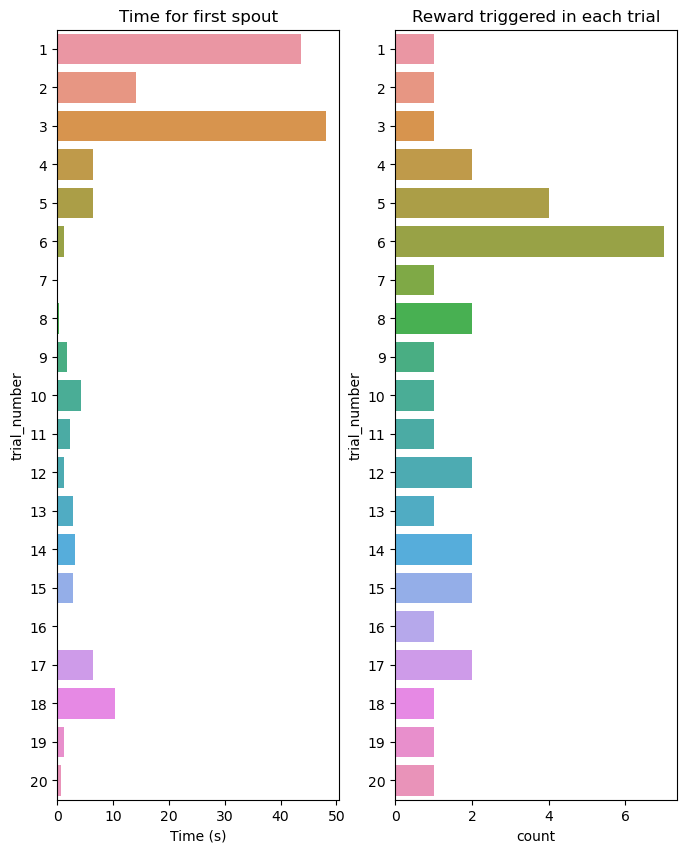

<Figure size 800x1200 with 0 Axes>

In [82]:
fig,ax = plt.subplots(1,2,figsize=(8,10))

sns.barplot( y='trial_number', x='time_first_spout', data=df_first_spout, ax=ax[0])
ax[0].set(xlabel='Time (s)',title='Time for first spout');

plt.figure(figsize=(8,12))
sns.countplot(y='trial_number', data=df_reward, ax = ax[1])
ax[1].set(title='Reward triggered in each trial');



### Summary statistics

In [83]:
print(f'Total reward: {len(df_reward)}')
print(f'Total trials: {df_events.iloc[-1].trial_number}')

#Calculate overall success rate
success_rate = (df_reward.groupby('trial_number').event_name.count()>0).mean()
print(f'Success rate: {success_rate}')

#average reward recieved per trial
average_reward = df_reward.groupby('trial_number').event_name.count().mean()
print(f'Average reward per trial: {average_reward}')

#average time to first spout in waiting_for_spout
print(f'Average first spout time {df_first_spout.time_first_spout.mean():.2f}s')

Total reward: 35
Total trials: 20
Success rate: 1.0
Average reward per trial: 1.75
Average first spout time 7.89s


# Event plots

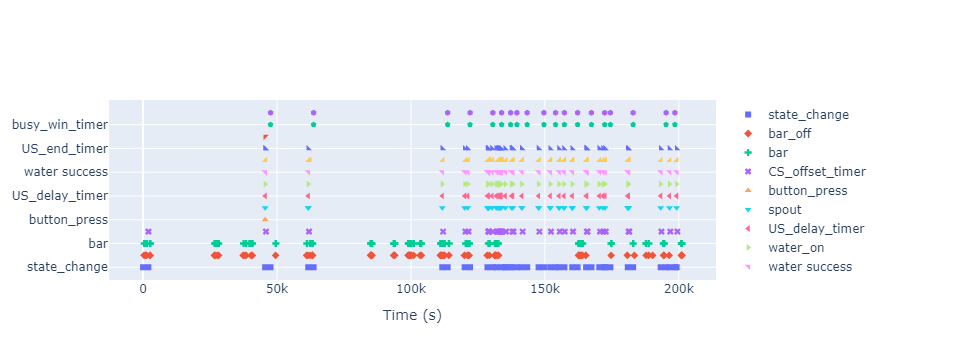

In [102]:
keys = df_events.event_name.unique()
state_def = [{'name': 'hold_for_water', 'onset': 'hold_for_water', 'offset': 'waiting_for_spout'},
                    {'name': 'waiting_for_spout', 'onset': 'waiting_for_spout',
                    'offset': 'busy_win'},
                    {'name': 'busy_win', 'onset': 'busy_win',
                        'offset': 'break_after_water'},
                    {'name': 'break_after_water', 'onset': 'break_after_water',    'offset': 'waiting_for_bar'},
                    {'name': 'break_after_no_water',       'onset': 'break_after_no_water', 'offset': 'waiting_for_bar'}]


plot_session(df_events, keys, state_def)